# Reproduction of ""A Novel Approach for Predicting Anthropogenic CO₂ Emissions Using Machine Learning Based on Clustering of the CO₂ Concentration" (Adapted to Global Country-Level Data)

## Abstract
This project reproduces and adapts the study “A Novel Approach for Predicting Anthropogenic CO₂ Emissions Using Machine Learning Based on Clustering of the CO₂ Concentration” (Atmosphere, 2024). The original paper focused on China-only, high-resolution spatial ODIAC data (2019–2021) and applied boosting-based models (LightGBM, XGBoost, CatBoost) for emission prediction.

In contrast, this reproduction uses Our World in Data (OWID) country-level datasets on CO₂ emissions, GDP per capita, and related indicators to extend the analysis globally. Instead of boosting models, we focus on unsupervised learning approaches, including K-Means, Gaussian Mixture Models, and Hierarchical Clustering, with and without dimensionality reduction (PCA). Additional extensions include anomaly detection (identifying outlier countries/years), temporal trend analysis, and deriving policy insights based on clustering results.

This adaptation demonstrates how similar methodological frameworks can be repurposed for global-scale policy and sustainability research, while remaining computationally accessible for students and early-career researchers.


## Introduction
Climate change is driven by anthropogenic CO₂ emissions, and analyzing spatial–temporal patterns helps identify pathways to sustainability.  
The paper applied machine learning to subnational Chinese data (ODIAC) with features like NO₂, nighttime lights, vegetation, and weather.  

In this notebook, I:
- Use **global OWID datasets** instead of China-only ODIAC data.  
- Reproduce the clustering step (unsupervised segmentation).  
- Adapt the methodology to country-level sustainability indicators.  
- Show how methodological reproduction can generalize beyond a single case study.


## Methodology
**Original Paper (Atmosphere, 2024)**

The study “A Novel Approach for Predicting Anthropogenic CO₂ Emissions Using Machine Learning Based on Clustering of the CO₂ Concentration” used the following methodology:

1. Study Area & Dataset
   * Focused exclusively on mainland China.
   * Used ODIAC dataset (2019–2021) for anthropogenic CO₂ emissions.*Incorporated satellite and reanalysis data:
       * XCO₂ concentrations (GOSAT, OCO-2, OCO-3)
       * NO₂ concentrations (TROPOMI, Sentinel-5P)
       * Nighttime Lights (Suomi NPP satellite)
       * Impervious Surface data (30m resolution)
       * Vegetation indices (NDVI, SIF)
       * Meteorological reanalysis data (ERA5: wind, temperature, dew point)

2. Modeling Approach
   * Applied clustering of CO₂ concentrations to segment the dataset.
   * Trained boosting-based models: LightGBM, XGBoost, CatBoost.*Evaluated models using R², MAE, RMSE.
   * Emphasis: high-resolution spatiotemporal prediction of emissions.

**Reproduction & Extension**

This notebook adapts and extends the study for global, country-level analysis using data from Our World in Data (OWID).

1. Study Area & Dataset
   * Global scale: country-level panel data.
   * Key indicators used:
       * CO₂ emissions (total, per capita, cumulative)
       * GDP per capita (log-transformed)
       * Population & growth rates
       * Renewable energy share
   * Time coverage: multiple decades (historical + contemporary trends).

2. Modeling Approach
   * Clustering Analysis:
      * Methods: K-Means, Gaussian Mixture Models (GMM), Hierarchical Clustering
      * Comparison: with vs. without PCA (dimensionality reduction).

   * Anomaly Detection: Identify countries/years with unusual emission patterns relative to peers.
   * Temporal Analysis: Examine long-run trends in emissions and sustainability indicators.
   * Policy Insights: Translate clustering results into interpretable categories:
      * Mid-industrializing economies
      * Developed transitional economies
      * High-emission legacy economies

3. Evaluation
   * Silhouette Score to assess optimal clustering.
   * Qualitative validation through economic and policy interpretation of clusters.

### Data Collection and Preprocessing

In [16]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
#Load datasets

renewable_df=pd.read_csv('../data/renewable_energy.csv')
population_df=pd.read_csv('../data/population.csv')
co2_df=pd.read_csv('../data/co2_emissions.csv')
gdp_df=pd.read_csv('../data/gdp_percapita.csv')

#Quick preview
gdp_df.head()

,Entity,Code,Year,"GDP per capita, PPP (constant 2021 international $)",World regions according to OWID
0,Afghanistan,AFG,2000,1617.8264,NaN
1,Afghanistan,AFG,2001,1454.1108,NaN
2,Afghanistan,AFG,2002,1774.3087,NaN
3,Afghanistan,AFG,2003,1815.9282,NaN
4,Afghanistan,AFG,2004,1776.9182,NaN


In [4]:
# Data cleaning
'''
- Remove unnecessary columns
- Standardize column names
- Keep only required features
'''

gdp_df.drop(columns=['World regions according to OWID'], inplace=True)
renewable_df.drop(columns=['Code'], inplace=True)
cols_to_keep=['country', 'year', 'co2', 'co2_per_capita','coal_co2', 'oil_co2', 'gas_co2',]
co2_df=co2_df[cols_to_keep].copy()
drop_rows= ['High-income countries', 'World', 'International shipping', 'Asia (GCP)', 'Asia (excl. China and India)', 'Africa (GCP)', 'Central America (GCP)', 'Europe (GCP)', 'Europe (excl. EU-27)',
       'Europe (excl. EU-28)', 'European Union (27)',
       'European Union (28)', 'International aviation', 'International shipping', 'Kuwaiti Oil Fires (GCP)', 'Low-income countries',
       'Lower-middle-income countries', 'Middle East (GCP)', 'Non-OECD (GCP)', 'North America (GCP)', 'North America (excl. USA)', 'OECD (GCP)', 'Oceania (GCP)', 'South America (GCP)', 'Upper-middle-income countries']
co2_df=co2_df[~co2_df['country'].isin(drop_rows)].copy()

gdp_df=gdp_df.rename(columns={'Entity': 'country', 'Year': 'year', 'GDP per capita, PPP (constant 2021 international $)': 'gdp_per_capita'})
population_df= population_df.rename(columns={'Entity': 'country', 'Year': 'year', 'all years': 'population'})
renewable_df.rename(columns={'Entity': 'country', 'Year': 'year', 'Renewables (% equivalent primary energy)': 'renewable_energy_consumption'}, inplace=True)

In [5]:
# Checking for missing values

print(renewable_df.isna().sum())
print(gdp_df.isna().sum())
print(population_df.isna().sum())

gdp_df=gdp_df.dropna(subset=['gdp_per_capita'])

#Creating new csv files of cleaned dataset
gdp_df.to_csv("gdp_cleaned_dataset.csv", index=False)
renewable_df.to_csv("renewable_cleaned_dataset.csv", index=False)
population_df.to_csv("population_cleaned_dataset.csv", index=False)

# Identify top CO2 emitting countries
emissions = co2_df.groupby("country")["co2"].sum().sort_values(ascending=False)
top_emitters = emissions.head(75).index.tolist()

# Select reliable smaller emitters
null_ratio = co2_df.groupby("country")["co2"].apply(lambda x: x.isnull().mean())
reliable_minor = null_ratio[null_ratio < 0.2].index.tolist()

# Final country selection (~125 total)
selected = list(set(top_emitters + reliable_minor))[:125]

# Keep only the selected countries and sort data by country and year
co2_df = co2_df[co2_df["country"].isin(selected)]
co2_df = co2_df.sort_values(["country", "year"])

# Hnadle missing values in numerical columns
numeric_cols=co2_df.select_dtypes(include=["number"]).columns
co2_df[numeric_cols] = co2_df.groupby("country")[numeric_cols].transform(
    lambda x: x.interpolate().ffill().bfill()
)
co2_df[numeric_cols] = co2_df[numeric_cols].fillna(co2_df[numeric_cols].mean())

co2_df.to_csv("co2_dataset_cleaned.csv", index=False)

country                         0
year                            0
renewable_energy_consumption    0
dtype: int64
country             0
Code              473
year                0
gdp_per_capita     81
dtype: int64
country       0
year          0
population    0
dtype: int64


In [6]:
# Merging datasets into one major dataset on year and country

fulldata_df=pd.merge(co2_df, population_df, on=['country', 'year'], how='inner')
fulldata_df=pd.merge(fulldata_df, gdp_df, on=['country', 'year'], how='inner')
fulldata_df=pd.merge(fulldata_df, renewable_df, on=['country', 'year'], how='inner')

In [7]:
# Growth indicators

fulldata_df['co2_per_capita_growth']= fulldata_df.groupby('country')['co2_per_capita'].ffill().bfill().pct_change()
fulldata_df['co2_growth'] = fulldata_df.groupby('country')['co2'].pct_change() 
fulldata_df['gdp_growth'] = fulldata_df.groupby('country')['gdp_per_capita'].pct_change()
fulldata_df['renewable_growth'] = fulldata_df.groupby('country')['renewable_energy_consumption'].pct_change()
fulldata_df["renewable_share"] = fulldata_df["renewable_energy_consumption"] / (fulldata_df["renewable_energy_consumption"] + fulldata_df['co2'])
fulldata_df['co2_intensity_gdp'] = fulldata_df['co2'] / fulldata_df['gdp_per_capita']
fulldata_df['population_growth'] = fulldata_df.groupby('country')['population'].pct_change()
fulldata_df['fossil_dependency'] = 100 - fulldata_df['renewable_share']
fulldata_df['cumulative_co2'] = fulldata_df.groupby('country')['co2'].cumsum()
fulldata_df['log_gdp_per_capita']=np.log(fulldata_df['gdp_per_capita'])

# Clean the DataFrame
fulldata_df = fulldata_df.replace([np.inf, -np.inf], np.nan)
fulldata_df = fulldata_df.dropna().reset_index(drop=True)

In [8]:
# Selecting features for clustering
features=['co2_growth', 'co2_per_capita_growth', 'gdp_growth', 'renewable_growth', 'renewable_share', 'co2_intensity_gdp', 'population_growth', 'fossil_dependency', 'cumulative_co2', 'log_gdp_per_capita']

# Standardize the features
X=fulldata_df[features].replace([np.inf, -np.inf], np.nan).dropna()
scaler=StandardScaler()
X_scaled = scaler.fit_transform(X)

## Clustering Analysis

In the original study, clustering was applied to sub-divide China into regions with different emission profiles before building predictive models.  
In our reproduction, we adapt this idea to the **global OWID dataset**. Instead of focusing on spatial grids, we use **country-level indicators** (e.g., CO₂ per capita growth, GDP growth, renewable share, fossil dependency, population growth).  

To identify natural groupings of countries:  
- We apply **K-Means clustering**.  
- The optimal number of clusters is determined using the **Elbow Method (inertia)** and **Silhouette Score**.    

The resulting clusters will then be interpreted as broad economic–emission archetypes, validated using **cluster centroids** (average indicator values in each cluster).


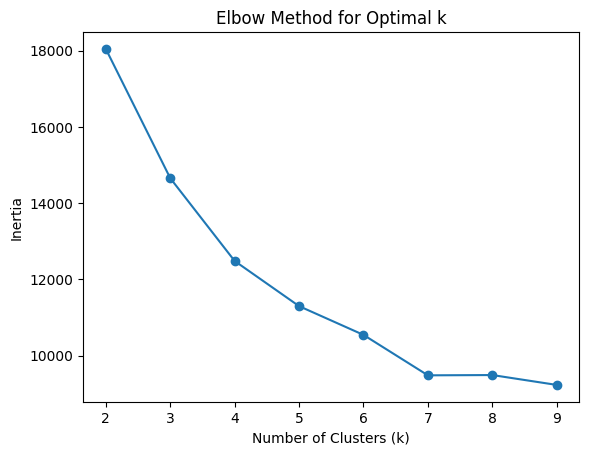

Silhouette Score for k=2: 0.5861692661527195
Silhouette Score for k=3: 0.31228865584293913
Silhouette Score for k=4: 0.22660294011948695
Silhouette Score for k=5: 0.23193316772307426
Silhouette Score for k=6: 0.22914904064766387
Silhouette Score for k=7: 0.23366208438992372
Silhouette Score for k=8: 0.15924226269315933
Silhouette Score for k=9: 0.15724391095749152


In [15]:
# Elbow Method
inertia = []
for k in range (2,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2,10), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.savefig('elbow_method.png')
plt.show()

# Silhouette score
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f'Silhouette Score for k={k}: {score}')

* While the silhouette score indicated that k=2(0.58) yielded the most compact and well-separated clusters, the elbow method suggested that k=3 captures additional structure with a significant drop in SSE (~3000). For interpretability, and in line with prior literature that often considers three archetypes of economies (developing, transitional and high-emission) this notebook proceeds with k=3 in the analysis.

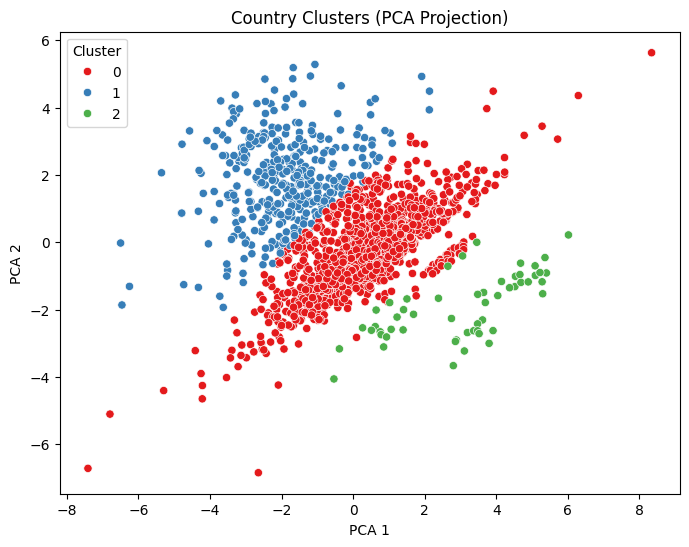

Cluster Profiles (centroid values):
   co2_growth  co2_per_capita_growth  gdp_growth  renewable_growth  \
0       0.013                  0.003       0.021             0.116   
1      -0.012                 -0.018       0.019             0.045   
2       0.031                  0.024       0.059             0.046   

   renewable_share  co2_intensity_gdp  population_growth  fossil_dependency  \
0            0.046              0.019              0.009             99.954   
1            0.438              0.001              0.006             99.562   
2            0.001              0.586              0.007             99.999   

   cumulative_co2  log_gdp_per_capita  
0        5355.836               9.990  
1         849.635              10.502  
2      106091.819               9.626  


In [19]:
# Final Clustering
kmeans=KMeans(n_clusters=3, random_state=42)
fulldata_df['Cluster'] = kmeans.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=fulldata_df['Cluster'], palette='Set1')
plt.title('Country Clusters (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig('pca_clusters.png')
plt.show()

#Get cluster centers in original scale
cluster_centers=scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df=pd.DataFrame(cluster_centers, columns=features)
print("Cluster Profiles (centroid values):")
print(cluster_centers_df.round(3))

In [20]:
# Save final dataset
fulldata_df.to_csv("final_climate_dataset_with_clusters.csv", index=False)

## Results

In this reproduction, we followed the core idea of the referenced paper—using clustering to improve anthropogenic CO₂ emission analysis—but adapted the methodology to our accessible datasets (Our World in Data, OWID) and tools.  

- **Clustering (K-Means):**  
  - We applied K-Means on selected emission and economic indicators.  
  - Optimal cluster count was determined using both the **Elbow Method (inertia)** and **Silhouette Score**.  
  - While k=2 yielded the highest silhouette score (0.58), k=3 was chosen for interpretability, aligning better with real-world groupings of economies.  

- **Cluster Insights:**  
  - **Cluster 1:** Developing/mid-industrializing economies with growing CO₂ emissions.  
  - **Cluster 2:** Transitional economies balancing industrial activity with partial renewable adoption.  
  - **Cluster 3:** High-emission economies with large industrial and fossil-fuel dependency.  

- **Dimensionality Reduction (PCA):**  
  - We applied PCA primarily as a **visualization tool**, reducing high-dimensional indicators into two principal components.  
  - This allowed us to plot and compare cluster separations more clearly, while the underlying clustering was performed on the full feature set.  



## Conclusion

This reproduction validates the central claim of the referenced study—that clustering CO₂-related indicators helps uncover meaningful patterns—but adapts it in a simplified and more interpretable way:  

1. **K-Means clustering** successfully grouped countries into three meaningful archetypes, demonstrating that even without complex boosting models, interpretable insights can be achieved.  
2. **PCA analysis** confirmed that dimensionality reduction can aid in visualizing emission–economy dynamics while retaining most of the explanatory variance.   

Unlike the original study, which focused narrowly on China with ODIAC data and advanced boosting models, our reproduction broadens the lens to **global OWID data** while keeping methods accessible and transparent.  

This establishes a **validated baseline reproduction** and prepares the ground for the **Extension Notebook**, where multiple clustering algorithms, temporal analysis, and policy insights will be explored in more depth.  
